In [1]:
expid='MC_O_20250411_000008'
sensor='R00_SG1'

In [2]:
from lsst.resources import ResourcePath
from astropy.io import fits
import os
import numpy
from astropy.table import Table
from dateutil.parser import parse
import re
import json
import matplotlib.pyplot as plt

#MC_C_20240918_000019_R40_SG1_guider.fits
p = re.compile( rf'MC_([OC])_(\d*)_(\d*)_(R.._S..)_guider.fits' )


In [3]:
def examineone(fname):
    oc, date, seqnum, sensor = p.match(fname).groups()
    path = f's3://embargo@rubin-summit/LSSTCam/{date}/MC_{oc}_{date}_{seqnum}/{fname}'
    rp=ResourcePath(path)
    with rp.open(mode="rb") as f:
        hdu_list = fits.open(f)
    hdus = hdu_list[2::2]  # for the mode with raw stamps
#    hdus = hdu_list[1:]   # for the mode without raw stamps
    timing = [ parse(hdu.header['STMPTIME']) for hdu in hdus ]
    mean = [ numpy.mean(hdu.data) for hdu in hdus ]
    stdnoise = numpy.mean(list(map( lambda x: numpy.std(x.data[1:-1,1:-1]), hdus))[1:]) 
    stdstdnoise = numpy.std(list(map( lambda x: numpy.std(x.data[1:-1,1:-1]), hdus))[1:]) 

    hz = 1/numpy.array(list(map(lambda x: x.total_seconds(), numpy.diff(numpy.array(list(map( lambda x: parse(x.header['STMPTIME']), hdus) )[1:]))))).mean()
    
    return {
        's3path': rp,
        'basename': rp.abspath().basename(),
        'noise': stdnoise,
        'std(noise)': stdstdnoise,        
        'Hz': hz,
        'mean': mean,
        'timing': timing
    }
    

In [4]:
table=Table(
    list(map( lambda x: examineone(x), [
        f'{expid}_R00_SG0_guider.fits',
        f'{expid}_R00_SG1_guider.fits',
        f'{expid}_R04_SG0_guider.fits',
        f'{expid}_R04_SG1_guider.fits',
        f'{expid}_R40_SG0_guider.fits',
        f'{expid}_R40_SG1_guider.fits',
        f'{expid}_R44_SG0_guider.fits',
        f'{expid}_R44_SG1_guider.fits'
    ])
       )
)
table['basename','noise','std(noise)','Hz' ] # ,'mean','timing']

basename,noise,std(noise),Hz
str40,float64,float64,float64
MC_O_20250411_000008_R00_SG0_guider.fits,4.5194103286523175,0.00956864986841111,1.6410041548828598
MC_O_20250411_000008_R00_SG1_guider.fits,5.218229197140519,0.015159213787157028,1.6759191369016446
MC_O_20250411_000008_R04_SG0_guider.fits,4.382210568788731,0.017499540669893628,1.6410041548828598
MC_O_20250411_000008_R04_SG1_guider.fits,5.159610607551897,0.025909611929889012,1.6060891728640756
MC_O_20250411_000008_R40_SG0_guider.fits,3.6647443223507565,0.009412238191462587,1.5711741908452916
MC_O_20250411_000008_R40_SG1_guider.fits,4.714264423201129,0.014846306334824325,1.6759191369016446
MC_O_20250411_000008_R44_SG0_guider.fits,4.082449493960998,0.013382225454461685,1.6759191369016446
MC_O_20250411_000008_R44_SG1_guider.fits,4.978723676972355,0.023108996862498822,1.6410041548828598


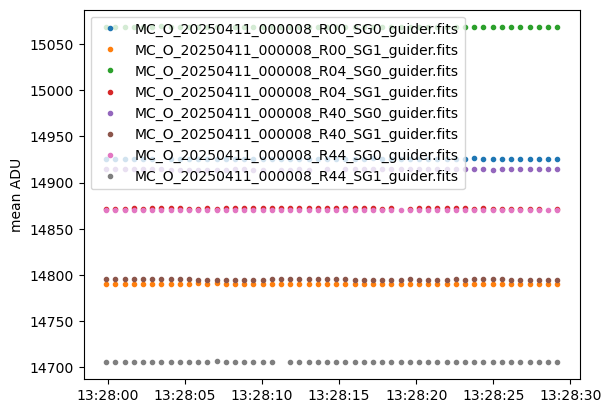

In [5]:
for row in table:
    plt.plot(row['timing'],row['mean'],'.',label=row['basename'])
plt.ylabel('mean ADU')
plt.legend()

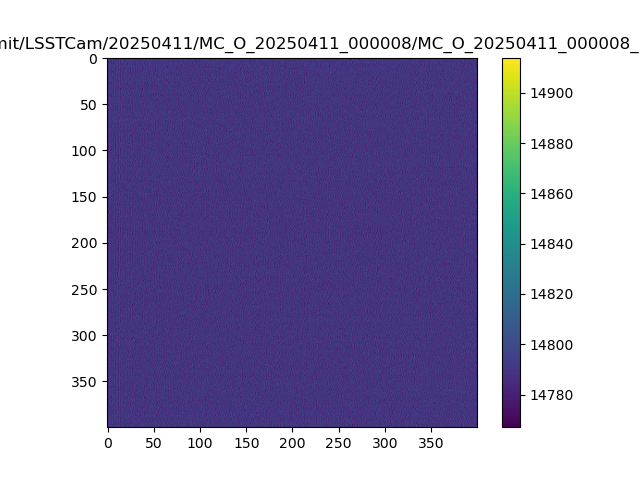

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from astropy.io import fits
from IPython.display import HTML
%matplotlib widget

s3file = table[table['basename']==f'{expid}_{sensor}_guider.fits']['s3path'][0]
with s3file.open(mode='rb') as f:
    fh = fits.open(f)

fig, ax = plt.subplots()

frames = [[plt.imshow(img.data, animated=True)] for img in fh[2::2]]
plt.colorbar()
plt.title(s3file)
ani = animation.ArtistAnimation(fig, frames, interval=120, blit=True, repeat_delay=1000)

#HTML(ani.to_html5_video())
#plt.show()

In [7]:
rp = ResourcePath(table[1]['s3path'].geturl().replace('.fits','.json'))
with rp.open(mode="r") as f:
    j=json.load(f)
print(json.dumps(j,indent=2))

{
  "__CONTENT__": "metadata",
  "SIMPLE": true,
  "BITPIX": 8,
  "NAXIS": 0,
  "EXTEND": true,
  "BINX": 1,
  "BINY": 1,
  "CCDGAIN": 1.0,
  "CCDNOISE": 10.0,
  "DETSIZE": "[1:4072,1:4000]",
  "DATE": "2025-04-11T13:28:00.432",
  "MJD": 60776.56111610774,
  "IMGTYPE": "UNKNOWN",
  "OBSID": "MC_O_20250411_000008",
  "BUNIT": "adu",
  "TIMESYS": "TAI",
  "INSTRUME": "lsstCam",
  "TELESCOP": "Simonyi Survey Telescope",
  "OBS-LONG": -70.749417,
  "OBS-LAT": -30.244639,
  "OBS-ELEV": 2663.0,
  "OBSGEO-X": 1818938.94,
  "OBSGEO-Y": -5208470.95,
  "OBSGEO-Z": -3195172.08,
  "RA": 214.9121805572917,
  "DEC": -63.75888930670833,
  "RASTART": 99.81916054791812,
  "DECSTART": -47.05399271819989,
  "RAEND": 99.9475211673765,
  "DECEND": -47.05369385304247,
  "ROTPA": 142.04943604479695,
  "ROTCOORD": "sky",
  "HASTART": 0.0,
  "ELSTART": 3.18055468146352e-15,
  "AZSTART": 147.988353828125,
  "AMSTART": 0.0,
  "HAEND": 0.0,
  "ELEND": 3.18055468146352e-15,
  "AZEND": 147.988353828125,
  "AMEND": 